In [1]:
import os
import sys
import glob
import datetime

from pixellib.custom_train import instance_custom_training
import tensorflow as tf

from bubble_predict import path_load, model_predict_maskrcnn, pickle_to_json

In [3]:
# warning 메시지 x
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

########################################################################################################################
# I.Parameter 확인 및 설정
# ----------------------------------------------------------------------------------------------------------------------
# 1. 변수 선언
# 2. SYSARGV에서 train_predict 식별
# 3. 작업일시 생성
# 4. 파일 path 지정
########################################################################################################################

# 1. 변수 선언
train_predict = None

# 2. SYSARGV에서 train_predict 식별
# argv = ["program_id", "train_predict"]
# for i in range(len(sys.argv)):
#     exec (argv[i] + "=" + "'" + sys.argv[i] + "'")

# 3. 작업일시 생성
now = datetime.datetime.now()
date = now.strftime("%Y%m%d")

# 4. 파일 path 지정
train_dataset_path, test_file_path, save_weight_path, image_save_path, pickle_save_path, json_save_path = path_load(date)

In [4]:
########################################################################################################################
# II.기포인식 AI모델 학습 및 예측
# ----------------------------------------------------------------------------------------------------------------------
# 1. mask-rcnn 모델 학습
#  1) 모델 파라미터 설정
#  2) mask-rcnn 모델 정의
#  3) pretrained 가중치 load
#  4) 학습 데이터셋 load
#  5) mask-rcnn 모델 학습
# 2. mask-rcnn 모델 예측
# 3. 예측 결과 값 후처리 진행
########################################################################################################################

# 1. mask-rcnn 모델 학습
# 시스템 입력 변수 train_predict가 train일 경우 학습 진행

In [5]:
# 1) 모델 파라미터 설정
detection_threshold = 0.7
num_classes = 1
batch_size = 2
num_epochs = 50
max_gt_instances = 200
layers = "all"

In [6]:
# 2) mask-rcnn 모델 정의
train_maskrcnn = instance_custom_training()
train_maskrcnn

In [7]:
train_maskrcnn.modelConfig(network_backbone = "resnet101", detection_threshold = detection_threshold, 
                           num_classes = num_classes, batch_size = batch_size)
train_maskrcnn

Using resnet101 as network backbone For Mask R-CNN model


In [8]:
train_maskrcnn.config.MAX_GT_INSTANCES = max_gt_instances

In [10]:
# 3) pretrained 가중치 load
weight_file = "{}/mask_rcnn_coco.h5".format(save_weight_path)
train_maskrcnn.load_pretrained_model(weight_file)
train_maskrcnn

In [ ]:
# 4) 학습 데이터셋 load
train_maskrcnn.load_dataset(train_dataset_path)

In [ ]:
# 5) mask-rcnn 모델 학습
train_maskrcnn.train_model(num_epochs = num_epochs, path_trained_models = save_weight_path,
                           layers = layers, augmentation = True)
print("Train Success")

In [ ]:
# 2. mask-rcnn 모델 예측
detection_max_instances = 200
model_predict_maskrcnn(test_file_path, save_weight_path, image_save_path, pickle_save_path, detection_max_instances)
print("Predict Success")

In [12]:
import os
import glob
import json
import pickle
import datetime

from imantics import Polygons, Mask
import numpy as np
import cv2
import pixellib
from pixellib.instance import custom_segmentation
import tensorflow as tf

from util.get_path import PATH_DICT


def get_mask_point(masks):
    contain_val = []

    for a in range(masks.shape[2]):
        m = masks[:,:,a]
        mask_values = Mask(m).polygons()
        val = mask_values.points
        contain_val.append(val)
    contain_val = np.asarray(contain_val, dtype = object)

    return contain_val


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_box_instances(image, boxes, masks, class_ids, class_name, scores, text_size, box_thickness, text_thickness):

    n_instances = boxes.shape[0]
    N = boxes.shape[0]
    colors = [(0.0, 1.0, 1.0)] * N

    txt_color = (255,255,255)
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = class_name[class_ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        color_rec = [int(c) for c in np.array(colors[i]) * 255]
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color_rec, box_thickness)
        image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, text_size,  txt_color, text_thickness)

    return image


def path_load(date):
    
    ########################################################################################################################
    # 파일 path 지정
    # ----------------------------------------------------------------------------------------------------------------------
    # 1. 파일 경로 설정
    # 2. 파일 경로 폴더 생성
    ########################################################################################################################
    
    # 1. 파일 경로 설정
    train_dataset_path = PATH_DICT["train_dataset_path"]
    test_file_path = PATH_DICT["test_file_path"]
    save_weight_path = PATH_DICT["save_weight_path"]
    image_save_path = "{}_{}".format(PATH_DICT["image_save_path"], date)
    pickle_save_path = "{}_{}".format(PATH_DICT["pickle_save_path"], date)
    json_save_path = "{}_{}".format(PATH_DICT["json_save_path"], date)

    # 2. 파일 경로 폴더 생성
    os.makedirs(image_save_path, exist_ok=True)
    os.makedirs(pickle_save_path, exist_ok=True)
    os.makedirs(json_save_path, exist_ok=True)
    
    return train_dataset_path, test_file_path, save_weight_path, image_save_path, pickle_save_path, json_save_path

In [13]:
# 1. test 이미지 파일 리스트 load
print("Test dataset load")

test_file_list = []

for path, dirs, files in os.walk(test_file_path):
    path = path.replace("\\", "/")
    for file in files:
        if os.path.splitext(file)[1].lower() == ".jpg" or os.path.splitext(file)[1].lower() == ".tif" or \
        os.path.splitext(file)[1].lower() == ".bmp":
            test_file_list.append(path + "/" + file)
test_file_list.sort()
test_file_list

Test dataset load


['./dataset/origin_data/01/01_0.jpg',
 './dataset/origin_data/02/02_Y4 Camera000000.tif',
 './dataset/origin_data/03/03_NX4-S2 Camera000000.jpg',
 './dataset/origin_data/04/04_Y4 Camera000369.tif',
 './dataset/origin_data/05/05_NX4-S2 Camera000000.jpg',
 './dataset/origin_data/06/06_NX4-S2 Camera000000.jpg',
 './dataset/origin_data/07/07_Y4 Camera000000.jpg',
 './dataset/origin_data/08/08_white_0001.jpg',
 './dataset/origin_data/09/09_Y4 Camera000000.jpg',
 './dataset/origin_data/10/10_Y4 Camera000000.jpg',
 './dataset/origin_data/11/11_Y4 Camera000000.jpg',
 './dataset/origin_data/12/12_Y4 Camera000000.jpg',
 './dataset/origin_data/13/13_Y4 Camera000000.bmp',
 './dataset/origin_data/14/14_Y4 Camera000000.bmp',
 './dataset/origin_data/15/15_Y4 Camera000000.bmp',
 './dataset/origin_data/16/16_Y4 Camera000000.bmp',
 './dataset/origin_data/17/17_Y4 Camera000000.bmp',
 './dataset/origin_data/18/18_2camera_turb_000001.jpg',
 './dataset/origin_data/19/19_PIV_lam_000001.jpg']

In [15]:
test_file_count = len(test_file_list)
print("Test {} images".format(test_file_count))

# 2. 예측 결과 저장 폴더 생성
# 1) folder name 리스트 load
unique_folder_list = list(set([test_file.split("/")[-2] for test_file in test_file_list]))

# 2) 저장 폴더 생성(image, pickle)
for unique_folder in unique_folder_list:
    # image folder
    os.makedirs("{}/{}".format(image_save_path, unique_folder), exist_ok=True)
    # pickle folder
    os.makedirs("{}/{}".format(pickle_save_path, unique_folder), exist_ok=True)

Test 19 images


In [17]:
detection_max_instances = 200
# 3. mask-rcnn 모델 예측
# 1) mask-rcnn 모델 정의
class_names = ["BG", "bubble"]
segment_image = custom_segmentation()
segment_image.inferConfig(num_classes = 1, class_names = class_names)
segment_image.DETECTION_MAX_INSTANCES = detection_max_instances
segment_image

In [23]:
# 2) 학습 가중치 load
weight_list = sorted(glob.glob("{}/*.h5".format(save_weight_path)), key=os.path.getctime)
weight_file = weight_list[-1]
# weight_file
segment_image.load_model(weight_file)

In [25]:
test_file = test_file_list[0]
    
save_name, exe = test_file.split("/")[-1].split(".")
folder_num = test_file.split("/")[-2]

pickle_tmp = segment_image.segmentImage(test_file, show_bboxes=True, mask_points_values=False)
pickle_tmp

({'rois': array([[241, 512, 294, 579],
         [ 40, 490,  83, 581],
         [300, 525, 365, 582],
         [146, 502, 192, 579]]),
  'class_ids': array([1, 1, 1, 1]),
  'scores': array([0.99987113, 0.9998692 , 0.9998264 , 0.9997626 ], dtype=float32),
  'masks': array([[[False, False, False, False],
          [False, False, False, False],
          [False, False, False, False],
          ...,
          [False, False, False, False],
          [False, False, False, False],
          [False, False, False, False]],
  
         [[False, False, False, False],
          [False, False, False, False],
          [False, False, False, False],
          ...,
          [False, False, False, False],
          [False, False, False, False],
          [False, False, False, False]],
  
         [[False, False, False, False],
          [False, False, False, False],
          [False, False, False, False],
          ...,
          [False, False, False, False],
          [False, False, False, False],
    

In [26]:
output_image_name="{}/{}/{}.{}".format(image_save_path, folder_num, save_name, exe)
output_image_name

'./dataset/output/image_20211123/01/01_0.jpg'

In [27]:
masks = pickle_tmp[0]["masks"]
masks

array([[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       ...,

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False,

In [28]:
contain_val = get_mask_point(masks)
contain_val

pickle_tmp[0]["file_name"] = "{}.{}".format(save_name, exe)
pickle_tmp[0]["imageHeight"] = pickle_tmp[1].shape[0]
pickle_tmp[0]["imageWidth"] = pickle_tmp[1].shape[1]
pickle_tmp[0]["masks"] = contain_val

array([[array([[544, 243],
       [543, 244],
       [541, 244],
       [540, 245],
       [535, 245],
       [534, 246],
       [533, 246],
       [532, 247],
       [529, 247],
       [528, 248],
       [526, 248],
       [525, 249],
       [524, 249],
       [523, 250],
       [522, 250],
       [520, 252],
       [519, 252],
       [519, 253],
       [518, 254],
       [517, 254],
       [515, 256],
       [515, 257],
       [514, 258],
       [514, 259],
       [513, 260],
       [513, 262],
       [512, 263],
       [512, 269],
       [513, 270],
       [513, 273],
       [514, 274],
       [514, 277],
       [515, 278],
       [515, 279],
       [517, 281],
       [517, 282],
       [520, 285],
       [521, 285],
       [523, 287],
       [524, 287],
       [525, 288],
       [526, 288],
       [527, 289],
       [528, 289],
       [529, 290],
       [531, 290],
       [532, 291],
       [550, 291],
       [551, 290],
       [554, 290],
       [555, 289],
       [557, 289],
    

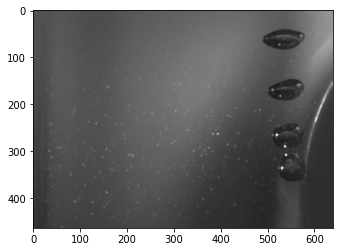

In [31]:

import matplotlib.pyplot as plt
image = cv2.imread(test_file)
plt.imshow(image)

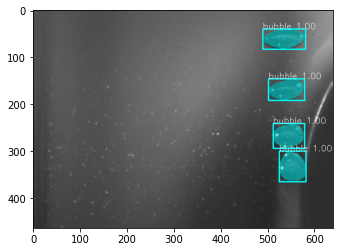

In [32]:
output_image = display_box_instances(image, pickle_tmp[0]["rois"], masks, pickle_tmp[0]["class_ids"], class_names,
                                     pickle_tmp[0]["scores"], text_size = 0.6, box_thickness = 2, 
                                     text_thickness = 0)
plt.imshow(output_image)